# Predicting Oil Production from Exclusively Public Records

Without access to proprietary geological data, this project predicts the quantity of oil produced from wells in an area of northern Colorado using data that is exclusively public and sourced from [Colorado's official ECMC website](https://ecmc.state.co.us/). The ECMC makes some of the data clean and easy for bulk download, and other data was scraped from their website. All wells in the dataset were drilled horizontally in the "Niobrara" geological formation (or similar).

The model built in this project is in two parts:
 * a series of exponential regression models fit to each well's production data; and
 * KNN to create a composite exponential model.

Specifically, it finds the *k*-nearest wells, pulls the coefficients for their exponential regression models, and averages those coefficients into a composite exponential curve -- weighting the averages by distance to the target with inverse-distance weighting (IDW).

### Report Sections

* Dataset
  * Well Location Data
  * Monthly Production Data
* Model
  * Part 1 - Exponential Regression
  * Part 2 - KNN
* Hyperparameter Tuning
* Evaluation
* Future Improvements


In [1]:
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split

from model.exp_regress import ExpRegressionModel, train_all_exp_regress
from model.nearest_wells import get_distance_calculator
from model import CompositeModelBuilder
from preprocess.prod_records import ProductionLoader
import evaluate
import graph_results
import utils
# Some functions only used in this notebook.
import demo_utils

In [2]:
DATA_ZIP = Path(r"../data/all_data.zip")
DEMO_DATA_DIR = Path(r"./_data")

# Configure paths/filenames of trained models / parameter tuning.
TRAINED_EXP_REGRESS_MODELS_DIR = Path(r"trained_expregress_models")
TRAINED_EXP_REGRESS_MODELS_DIR.mkdir(parents=True, exist_ok=True)
TRAINED_EXP_REGRESS_FN_TEMPLATE = "exp_regress_models_{weight}.csv"
TUNING_RESULTS_FP = Path("tuning_results.csv")

# ...And for monthly production records
PRODUCTION_RECORDS_DIR = DEMO_DATA_DIR / "production_records"
PRODUCTION_CSV_FN_TEMPLATE = "{api_num}_production_data.csv"

In [3]:
# print("Unzipping data... ", end='')
# with zipfile.ZipFile(DATA_ZIP, 'r') as data_zip_file:
#     data_zip_file.extractall(DEMO_DATA_DIR)
# print('Done.')

# The Dataset

## Well Location Data

The data collection, combining, and preprocessing have mostly been completed and saved to `selected_wells_working_data.csv` prior to this demo.

Here's a quick explanation of the important data:
  * __API Number__ -- a unique identifier for each well, in the format `05-123-XXXXX`
  * __Surface hole location__ (SHL) -- the lat/long coord where the well is drilled at the surface
  * __Bottom hole location__ (BHL) -- the lat/long of the underground termination point of the lateral \*
  * __Midpoint__ between the SHL and BHL (itself a lat/long coord)
  * __Length__ of the underground lateral \*

  \* *The __lateral__ is the part of the well that is drilled horizontally, roughly parallel to the surface of the earth. More on that later.*

In [4]:
# Previously processed to add midpoints, lateral lengths, and other data.
well_data_fp = DEMO_DATA_DIR / "selected_wells_working_data.csv"
wells = pd.read_csv(well_data_fp)

In [5]:
important_fields = ['API_Label', 'lat_shl', 'long_shl', 'lat_bhl', 'long_bhl', 'lat_midpoint', 'long_midpoint', 'lateral_length_ft']
wells[important_fields].head()

,API_Label,lat_shl,long_shl,lat_bhl,long_bhl,lat_midpoint,long_midpoint,lateral_length_ft
0,05-123-31642,40.755031,-104.104749,40.74465,-104.09018,40.749840,-104.097465,5342.0
1,05-123-32812,40.667909,-104.093667,40.65689,-104.09359,40.662399,-104.093628,3745.0
2,05-123-33023,40.759280,-103.877940,40.75685,-103.86228,40.758065,-103.870110,4381.0
3,05-123-33065,40.771792,-103.858169,40.77184,-103.85792,40.771816,-103.858045,4409.0
4,05-123-33067,40.759950,-103.880660,40.76011,-103.89240,40.760030,-103.886530,3430.0


The selected area is densely drilled but asymmetrical. There are more wells in the northeastern area than west and south.

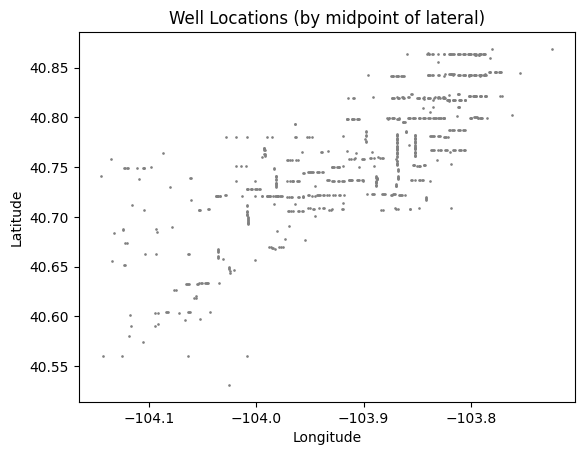

In [6]:
plt.scatter(wells['long_midpoint'], wells['lat_midpoint'], s=0.8, c='gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Well Locations (by midpoint of lateral)')
plt.show()

*__Side note:__ You might notice many of the well locations roughly form north/south or east/west lines. If you're curious why, it's primarily because Colorado is on a square grid survey system called the [PLSS](https://en.wikipedia.org/wiki/Public_Land_Survey_System); and for practical and regulatory reasons, operators often design their drilling patterns in accordance with that grid.*

## Monthly Production Data

Each well's production records were downloaded separately. The only important data here for our purposes is the quantity of oil production (measured in barrels, or BBLs) each month.

In [7]:
# Utility to load monthly production records for a given well (by its API number).
production_loader = ProductionLoader(
    prod_records_dir=PRODUCTION_RECORDS_DIR,
    prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE,
    use_cache=True,  # Save some load time
    apply_get_prod_window=True,
    # kwargs for get_production_window(), to get consistent timeframe
    # for all wells in the train/test data.
    min_months=36,
    max_months=48,
    discard_gaps=True,
)

In [8]:
# Create a separate sample loader to pull the full production history for this demo.
example_loader = ProductionLoader(
    prod_records_dir=PRODUCTION_RECORDS_DIR,
    prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE)
example_api_num = '05-123-31642'
example_prod = example_loader.load(example_api_num)
# We only care about which month and the quantity of monthly production.
relevant_fields = ['First of Month', 'Oil Produced']
example_prod[relevant_fields].head()

,First of Month,Oil Produced
3,2011-01-01,4957.0
4,2011-02-01,3579.0
5,2011-03-01,3766.0
6,2011-04-01,3185.0
7,2011-05-01,3032.0


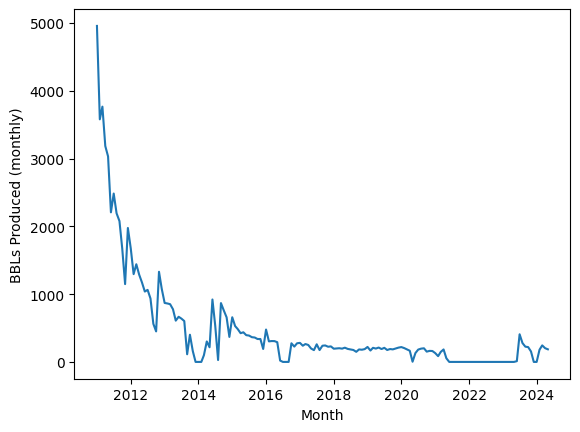

In [9]:
ax = plt.subplot()
ax.plot(example_prod['First of Month'], example_prod['Oil Produced'])
ax.set_xlabel('Month')
ax.set_ylabel('BBLs Produced (monthly)')
plt.show()

The actual quantity of oil or gas produced from a well is quite noisy, but overall it exhibits a ["decline curve"](https://www.investopedia.com/terms/d/decline-curve.asp). The vast majority of production from a well will be obtained shortly after its completion, then it tapers off significantly (unless the operator reworks the well later on). That means that investors will obtain nearly all of the income from a well early on, so we'll focus on the first four years for each well.

# The Model

## Part 1 - Exponential Regression

We model the decline curve by fitting an exponential curve to the actual production (reported monthly but predicted daily). We can use different weightings to skew the prediction more or less in favor of higher-producing months, which is one area for tuning later.

Specifically, weights for each data point are calculated as `(bbls_per_day / lateral_length_ft) ** exp_reg_power`, where `bbls_per_day / lateral_length_ft` is the target variable (which later gets converted to `bbls_per_day` when making predictions). The higher the power, the more strongly the curve is weighted toward large data points.

In [10]:
example_well = wells.iloc[0, :]
api_num = example_well['API_Label']
lat_len = example_well['lateral_length_ft']
monthly_prod_records_all = production_loader.load(api_num)
# Clean up the records so that we are looking only at the first 48 months of actual production.
monthly_prod_records = utils.get_prod_window(monthly_prod_records_all, min_months=36, max_months=48, discard_gaps=True)

# Different weightings we'll try.
exp_weight_pows = [2.0, 1.5, 1.0, 0.75, 0.5, 0.375, 0.25, 0.125]
# Store predictions for each model.
weights_predictions = {}

for wp in exp_weight_pows:
    exp_reg = ExpRegressionModel()
    exp_reg.fit(monthly_prod_records, lateral_length_ft=lat_len, weight_power=wp)
    cumulative_days = utils.get_cumulative_days(monthly_prod_records)
    predicted = exp_reg.predict_bbls_per_calendar_day(cumulative_days)
    weights_predictions[wp] = predicted

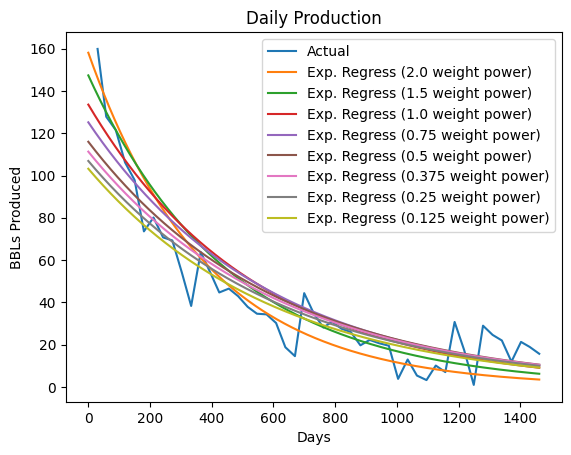

In [11]:
labels = [f"Exp. Regress ({wp} weight power)" for wp in weights_predictions.keys()]
all_predictions = list(weights_predictions.values())
graph_results.graph_results_multiple(monthly_prod_records, all_predictions, labels)

This is a two-part model that combines multiple exponential regression with KNN, so I'll hold off on assessing the different weightings.

For now, we can train exponential regression models for all wells in the dataset, using a weighting value of `0.5`. (We will later try different weightings during tuning.)

In [12]:
wp = 0.5
fp = TRAINED_EXP_REGRESS_MODELS_DIR / TRAINED_EXP_REGRESS_FN_TEMPLATE.format(weight=wp)
if fp.exists():
    print(f"Loading models with weight power {wp}... ", end='')
    expreg_models = pd.read_csv(fp)
else:
    print(f"Training all with weight power {wp}... ", end='')
    expreg_models = train_all_exp_regress(
        wells,
        prod_records_dir=PRODUCTION_RECORDS_DIR,
        prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE,
        weight_power=wp,
    )
print("Done")

Loading models with weight power 0.5... Done


Some wells do not have the minimum number of months that saw any production (36 months in this demo), so we discard those wells before performing KNN.

In [13]:
# Whether there was enough data for a given well will not change based on
# the weighting used, we can use these results to determine the wells that
# are usable for all subsequent models.
usable_api_nums = expreg_models[expreg_models['sufficient_data'] == True]['API_Label']
usable_wells = wells[wells['API_Label'].isin(usable_api_nums)]
print(f"{len(wells)} total wells")
print(f"{len(usable_wells)} wells with at least 36 months of production")

831 total wells
816 wells with at least 36 months of production


### Normalizing by length of lateral

One important note is that modern oil wells are drilled down to the target geological formation, and then across or "laterally" (roughly parallel to the surface of the earth). That part of the well is called the *__"lateral"__* (or sometimes the "horizontal leg"), and it can vary from a few hundred feet to several miles long. The longer the lateral, the more area the well is producing from. To account for this, we normalize the quantity of production (BBLs) to __BBLs *per foot*__ before training, and then convert back to (total) BBLs when making predictions. This is handled internally by the ``ExpRegressionModel`` class, and that's why `lateral_length_ft` is a parameter.

## Part 2 - KNN with Inverse-Distance Weighting (IDW)

Next, we find the k-nearest wells to our target, and then build an exponential regression model that is a *composite* of the models for those k-nearest wells. Specifically, we use IDW to determine the weighting of each component well (i.e., the closer the well to our target, the higher its weighting) and take the weighted average of each model's `a` and `b` coefficients.

For each well, we'll use the midpoint between the SHL and BHL as its location, in order to simplify finding distances for KNN. Neither the SHL (location at ground level) or BHL (termination point below ground, if viewed from above) are suitable on their own for calculating distance, because two wells can be drilled right next to one another but then horizontally in opposite directions. In fact, this is extremely common, because it allows an operator to reduce the area they need to drill on, and it reduces the number of collection points for trucks and pipelines.

In [14]:
# Creating a calculator with all available wells allows for caching distance calculations.
dist_calculator = get_distance_calculator(wells=usable_wells)

k = 8
example_well = usable_wells.iloc[0, :]
target_api_num = example_well['API_Label']  # '05-123-31642'
lat_len = example_well['lateral_length_ft']
# For this demo, consider every well except the target well itself.
training_wells = usable_wells.drop(usable_wells[usable_wells['API_Label'] == target_api_num].index)
coefs = CompositeModelBuilder.extract_coefs_from_df(expreg_models)
builder = CompositeModelBuilder(training_wells, k, coefs, dist_calculator)
composite_model = builder.knn_well(target_api_num, idw_power=1.05)

In [15]:
monthly_prod_records_all = production_loader.load(api_num)
# Clean up the records so that we are looking only at the first 48 months of actual production.
monthly_prod_records = utils.get_prod_window(monthly_prod_records_all, min_months=36, max_months=48, discard_gaps=True)
cumulative_days = utils.get_cumulative_days(monthly_prod_records)
predicted = composite_model.predict_bbls_per_calendar_day(cumulative_days, lateral_length_ft=lat_len)

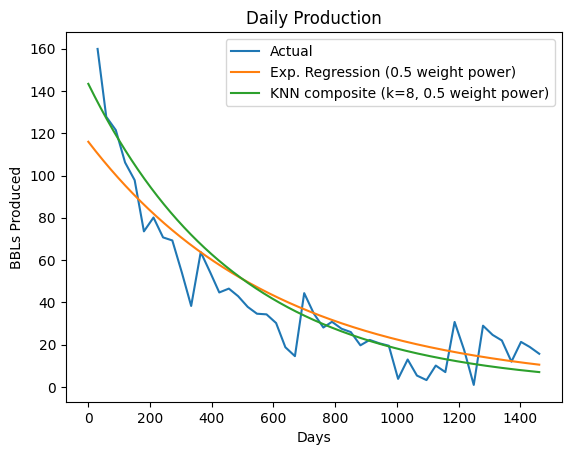

In [16]:
selected_predictions = [all_predictions[4], predicted]
graph_results.graph_results_multiple(monthly_prod_records, selected_predictions, prediction_labels=['Exp. Regression (0.5 weight power)', 'KNN composite (k=8, 0.5 weight power)'])

The graph above shows the actual production for this well, and two curves showing the predictions. One prediction curve is the exponential regression that was fitted to this well's actual production (using 0.5 weight power); and the other is the composite model, drawing instead from the 8 nearest wells (excluding this well itself).

This graph is included to show a "self-trained" exponential regression curve (i.e., trained on this well's own production data) against the KNN composite curve. In a real world prediction, the self-trained exponential curve wouldn't be available, and we would only see the KNN composite.

# Hyperparameter Tuning

We'll do a 75/25 train/test split, then use 10-fold cross-validation to tune the model on the training wells. We'll perform a grid search with these hyperparameter values:
 * various weightings for the exponential regression models from `0.125` to `2` (with more granularity at toward the lower end of the range)
 * `k` values of `[2, 3, ..., 12]`
 * IDW powers of `[0.0, 0.05, ..., 2.0]`

We'll calculate metrics (MAPE, MAE, and RMSE) for total production after 24, 36, and 48 months.

Note that the first cross-validation takes a minute or so, but every subsequent CV pass takes only a few seconds because distance calculations and the loaded/preprocessed production records get cached during that first pass. We also load existing models and tuning results, rather than calculating them again. (Testing 3608 different parameter sets took about 2.5 hours on my machine, although if I'd been short on time, I could have been more selective about the ranges of parameter values to try.)

In [17]:
wells_train, wells_test = train_test_split(usable_wells, test_size=0.25, random_state=42)

In [18]:
# Parameter values we'll consider.
exp_reg_weight_vals = [2.0, 1.5, 1.0, 0.75, 0.5, 0.375, 0.25, 0.125]
knn_k_vals = list(range(2, 13))
# [0.0, 0.05, 0.10, ..., 2.0]
idw_power_vals = [float(round(x, 2)) for x in np.linspace(0.0, 2.0, 41)]

# sklearn metrics functions
metrics = {
    'MAE': mean_absolute_error,
    'MAPE': mean_absolute_percentage_error,
    'RMSE': root_mean_squared_error,
}

# Train all the component exponential regression models.
exp_reg_models_by_weights = demo_utils.prepare_exp_regress_models(
    wells_all=usable_wells,
    production_records_dir=PRODUCTION_RECORDS_DIR,
    production_csv_fn_template=PRODUCTION_CSV_FN_TEMPLATE,
    exp_regress_dir=TRAINED_EXP_REGRESS_MODELS_DIR,
    exp_regress_fn_template=TRAINED_EXP_REGRESS_FN_TEMPLATE,
)

# Run the grid search.
tuning_results = demo_utils.grid_search(
    wells_train=wells_train,
    tuning_results_fp=TUNING_RESULTS_FP,
    production_loader=production_loader,
    distance_calculator=dist_calculator,
    metrics=metrics,
    exp_reg_models_by_weights=exp_reg_models_by_weights,
    exp_reg_weight_power_vals=exp_reg_weight_vals,
    knn_k_vals=knn_k_vals,
    idw_power_vals=idw_power_vals,
)

Training initial exponential regression models...
 -- Loading existing models with weight 2.0...
 -- Loading existing models with weight 1.5...
 -- Loading existing models with weight 1.0...
 -- Loading existing models with weight 0.75...
 -- Loading existing models with weight 0.5...
 -- Loading existing models with weight 0.375...
 -- Loading existing models with weight 0.25...
 -- Loading existing models with weight 0.125...
Initial exponential regression models complete.

Loading existing tuning results...

Beginning cross-validation...
All cross-validation complete.


In [19]:
# Show best parameters for mean absolute error at 48 months.
mae_at_48_months = demo_utils.rank_best(tuning_results, 'MAE', 48)
mae_at_48_months.head()

,param_set,exp_reg_weight,knn_k,idw_power,MAE_48
0,"(0.25, 8, 1.0)",0.25,8,1.00,23260.387397
1,"(0.25, 8, 0.95)",0.25,8,0.95,23260.759354
2,"(0.25, 8, 1.05)",0.25,8,1.05,23268.645197
3,"(0.25, 8, 0.9)",0.25,8,0.90,23274.194072
4,"(0.25, 10, 1.05)",0.25,10,1.05,23279.453673


All of the metrics prefer `k` values between `7` and `10` at all three checkpoints. MAPE prefers `exp_reg_weight=0.125`, but MAE and RMSE prefer `0.25`. And all metrics seem to like `idw_power` values around `0.9` to `1.0`. That being the case, let's visualize some metrics for parameter sets with `6 <= k <= 12` and `0.85 <= idw_power <= 1.15`. (We'll lock in `exp_reg_weight=0.25` to visualize only 2 dimensions.)

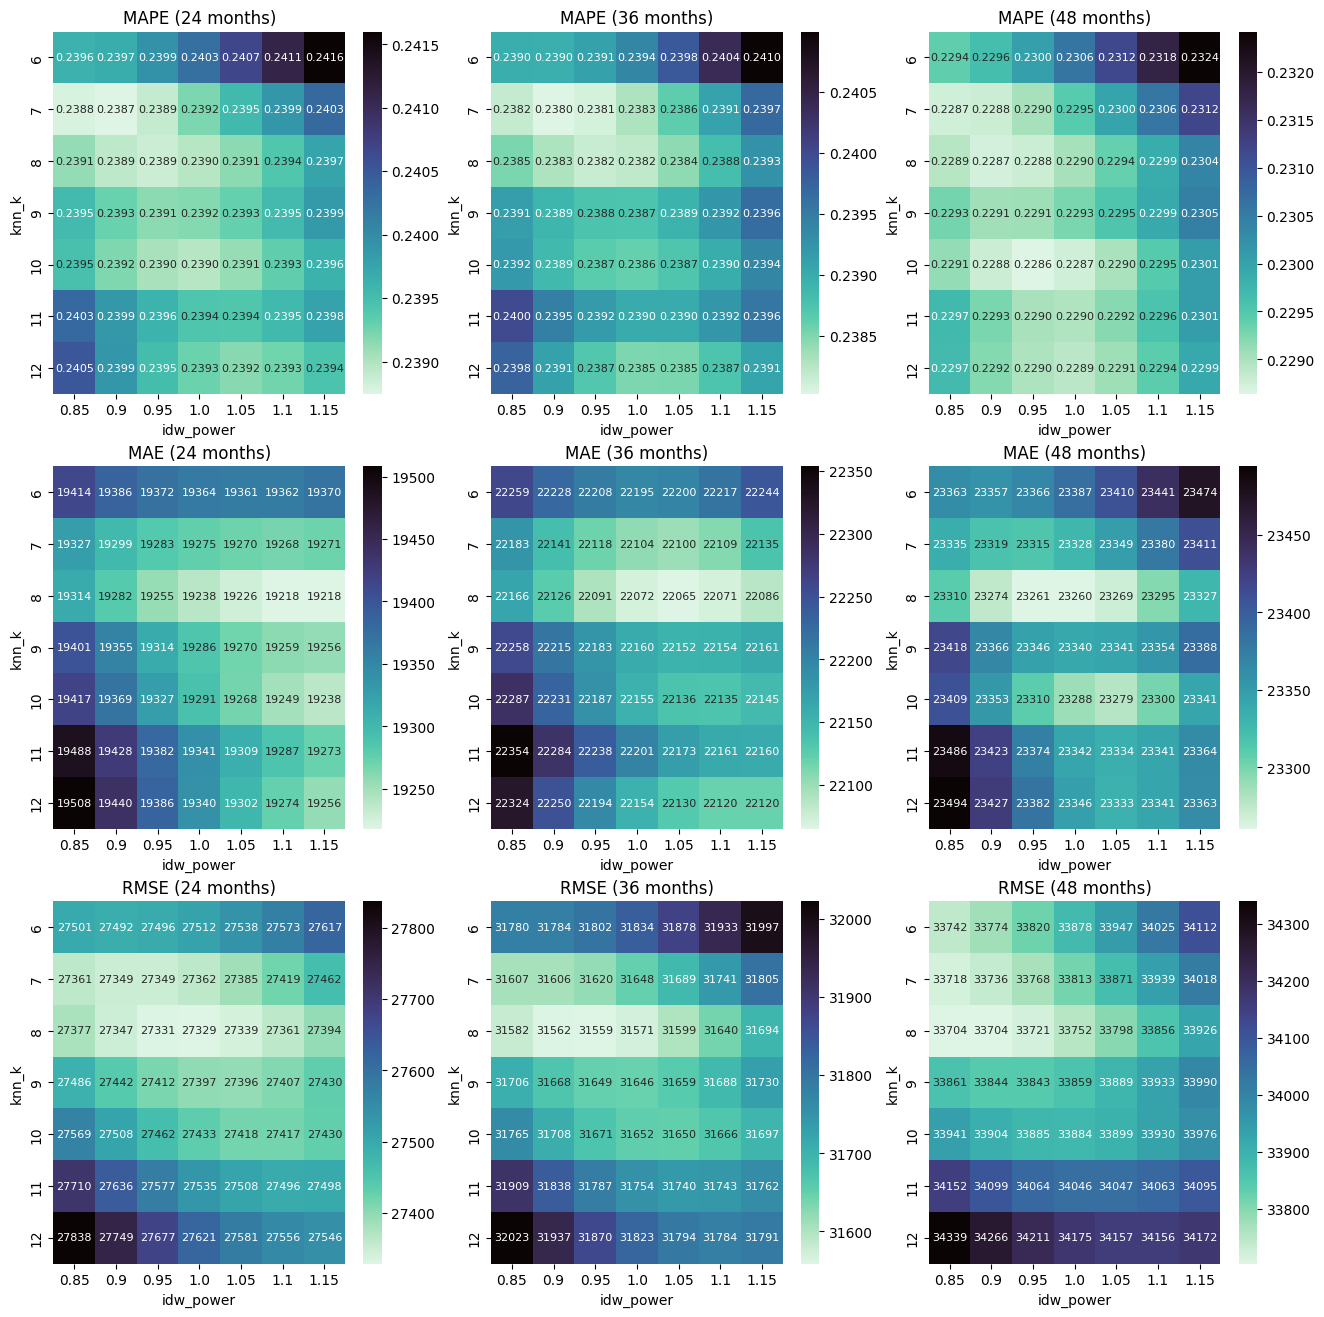

In [20]:
metric_names = ['MAPE', 'MAE', 'RMSE']
checkpoints = [24, 36, 48]
exp_reg_wt = 0.25

mask = ((tuning_results['exp_reg_weight'] == exp_reg_wt)
        & (tuning_results['knn_k'] >= 6)
        & (tuning_results['knn_k'] <= 12)
        & (tuning_results['idw_power'] >= 0.85)
        & (tuning_results['idw_power'] <= 1.15))
subset = tuning_results[mask]

demo_utils.metrics_heatmaps(
    tuning_results_subset=subset,
    metric_names=['MAPE', 'MAE', 'RMSE'],
    month_checkpoints=[24, 36, 48],
    cmap='mako_r',
    heatmap_txt_fmt={'MAPE': '.4f', 'MAE': '.0f', 'RMSE': '.0f'}
)

MAPE's preferences shift between `k=7` to `k=10`, depending on the checkpoint; but in general, the MAPE scores are tightly grouped anyway. But `k=8` is the clear favorite for MAE and RMSE.

If we want to optimize early predictions (24 or 36 months), we might choose somewhat higher IDW weighting; but by 48 months, MAPE prefers `(k=8, idw_power=1.0)`. 4 years is a reasonable timeframe for when an oil well should "payout" (income from production equals the initial investment), so we'll defer to that checkpoint. In any case, at all three checkpoints, most scores around `(k=8, idw_power=1.00)` are tightly grouped: most MAPE scores are within 0.001 of each other, and MAE and RMSE scores are within 100 BBLs or so.

## Evaluation

Based on the hyperparameter tuning above, we'll evaluate the model with `(exp_regress_weight=0.25, k=8, idw_power=1.0)`.

In [21]:
selected_exp_reg_weight_power = 0.25
selected_knn_k = 8
selected_idw_power = 1.0
month_checkpoints = [24, 36, 48]

predictions = evaluate.run_predictions_at_checkpoints(
    wells_train,
    wells_test,
    production_loader,
    exp_reg_models=exp_reg_models_by_weights[selected_exp_reg_weight_power],
    knn_k=selected_knn_k,
    idw_power=selected_idw_power,
    distance_calculator=dist_calculator,
    month_checkpoints=month_checkpoints,
)

In [22]:
scores = evaluate.evaluate(predictions, month_checkpoints, metrics)
scores

,month_checkpoint,MAE,MAPE,RMSE
0,24,19621.182361,0.238188,29189.842755
1,36,22758.312536,0.240853,33528.223650
2,48,23966.508520,0.234868,36122.778512


The MAPE at all three checkpoints is around 23.5% to 24%; and the MAE at 48 months is about 24,000 BBLs. These errors are higher than we would use for real world investment decisions. If a barrel of oil sells for \\$75, then a MAE of 24,000 BBLs is equivalent to approximately \\$1.8 million total after 4 years. (For context, a typical oil well might cost around \\$10 million to drill.)

Even so, these scores are respectable for a model that uses only public data, without access to any sophisticated geological data.

## Visualizing Error by Location

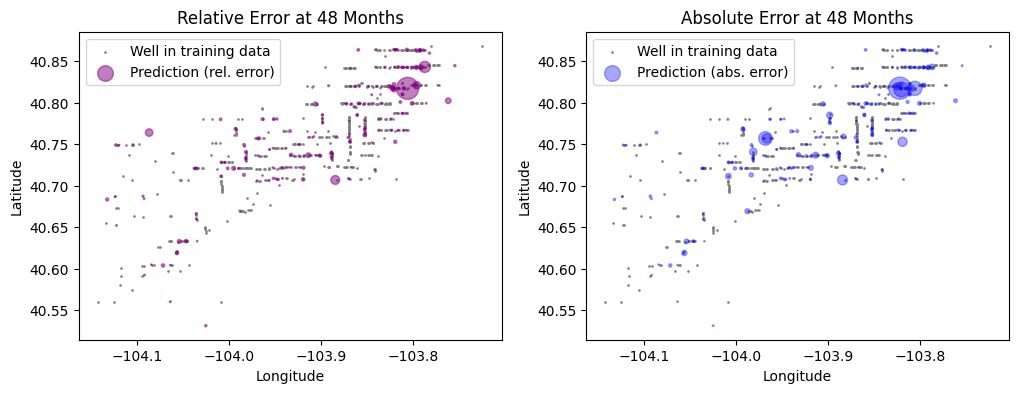

In [23]:
fig, axs = demo_utils.plot_errors(usable_wells, predictions, 48, rel_pow=4.5, train_color='gray', rel_color='purple')

*Note that magnitude of dots isn't really "apples to apples" between the relative error and absolute error plots.*

I might have expected the largest errors in the western and southern areas, where the density is lower. But the largest relative and absolute errors are found in the northeast. Of course, because there are more wells in that area, there are more opportunities for large errors.

Even so, some of the larger errors do notably occur around the edges of the dataset, or deep inside the dataset but at the edges of "groups" of wells. This makes some sense: My intuition points to the fact that their respective models are drawing from wells in a more linear direction (generally toward the center(ish) of the dataset or toward their respective well "group"), whereas wells closer to the middle might have the benefit of averaging wells in all directions.

Furthermore, if an oil company is drilling wells in a line, they might eventually reach the edge of the reservoir of oil that they are targeting. This might partially explain why some of the larger errors are seen near the end of these lines: possibly the company drilled wells beyond the "sweet spot", and the outermost wells are producing less than their nearby peers, but the model still expects them to produce comparably.

# Future Improvements

I have some ideas of how to potentially improve the model, either with different techniques or supplementing with additional or better data, which might or might not be available.

### Modified KNN / "fuzzy" K

Instead of finding the *k* nearest neighbors of a target location, a variation might be to find *all* neighbors within some parameter-specified distance threshold -- and still weight them by distance. This could be bounded by a maximum number of wells to include, and also a minimum (i.e., go beyond the distance threshold until we have at least `k_min` wells). I suspect this could have better results in areas with fewer wells, where there might be only 2 or 3 that are "close", because we would avoid reaching for distant wells with relatively little predictive value. But it is possible that IDW already accomplishes much of this, so testing is necessary to know for sure.

### More accurate location data

Ideally, more accurate distances could be achieved if we used the midpoint of the lateral itself, which might not be *precisely* the same as the midpoint between the SHL and BHL (for reasons I won't go into here), but that data isn't easily available for Colorado wells. It *could* probably be calculated with shapefiles available on Colorado's ECMC website, which might be worthwhile if we're trying to fully optimize this model.

### Additional completion data

Knowing the length of the lateral for each well is important, because it reveals how large of an area oil is being drawn from. But another data field that would be nice to have is the number of perforations in the lateral (the number of holes that are blown into the sides of the lateral with explosives, allowing oil to flow into the lateral). This data is available for some of the wells, but not all.

### Reduce predicted production if nearest wells primarily lie in one direction

Visualizing the errors above and seeing relatively large errors at the edge of groups of wells gave me an idea: We might calculate the average vector from the target to its `k` nearest wells. If the vector is large (i.e. the nearest wells lie generally in one direction from the target), we might reduce the predictions by some factor. I would have to experiment to see if this would actually help, but I wonder if this would improve predictions for wells that approach the edge of a target reservoir of oil, which is not *directly* apparent from the data we have available from the ECMC website.
